<a href="https://colab.research.google.com/github/ImNotDanish05/2025_KC_TI-1A/blob/main/P11_Convolutional%20Neural%20Network%20(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
print(tf.__version__)

2.18.0


In [2]:
"""
List Dir: https://api.github.com/repos/ImNotDanish05/2025_KC_TI-1A/contents/Data/P11/images
Open File: https://raw.githubusercontent.com/ImNotDanish05/2025_KC_TI-1A/main/Data/P11/images
"""

base_dir = 'https://api.github.com/repos/ImNotDanish05/2025_KC_TI-1A/contents/Data/P11/images'
train_dir = base_dir + '/train'
validation_dir = base_dir + '/val'

In [6]:
import requests
from urllib.parse import urlparse
def listdirx(dirx):
  response = requests.get(dirx)
  if response.status_code == 200:
      files = response.json()
      print(dirx)
      for file in files:
          print(f"- {file['name']}")
  else:
      print(f"Gagal mengambil data. Status: {response.status_code}")
def list_all_png_from_github_api(api_url, collected=[]):
    collected = []
    response = requests.get(api_url)
    if response.status_code != 200:
        print(f"❌ Gagal mengakses {api_url} | Status: {response.status_code}")
        return collected

    items = response.json()
    for item in items:
        if item['type'] == 'file' and item['name'].endswith('.png'):
            collected.append(item['download_url'])
        elif item['type'] == 'dir':
            list_all_png_from_github_api(item['url'], collected)
    return collected

def download_images(image_urls, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for url in image_urls:
        filename = os.path.basename(urlparse(url).path)
        save_path = os.path.join(save_dir, filename)

        response = requests.get(url)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(response.content)
            print(f"✅ Downloaded: {save_dir}/{filename}")
        else:
            print(f"❌ Gagal download: {filename}")

In [7]:
listdirx(train_dir)
listdirx(validation_dir)

https://api.github.com/repos/ImNotDanish05/2025_KC_TI-1A/contents/Data/P11/images/train
- .DS_Store
- clean
- messy
https://api.github.com/repos/ImNotDanish05/2025_KC_TI-1A/contents/Data/P11/images/val
- clean
- messy


TensorFlow

Documentation: https://keras.io/api/data_loading/image/

In [8]:
train_clean_urls = list_all_png_from_github_api(train_dir + "/clean")
train_messy_urls = list_all_png_from_github_api(train_dir + "/messy")
validation_clean_urls = list_all_png_from_github_api(validation_dir + "/clean")
validation_messy_urls = list_all_png_from_github_api(validation_dir + "/messy")
test_urls = list_all_png_from_github_api(base_dir + "/test")
download_images(train_clean_urls, 'dataset/train/clean')
download_images(train_messy_urls, 'dataset/train/messy')
download_images(validation_clean_urls, 'dataset/val/clean')
download_images(validation_messy_urls, 'dataset/val/messy')
download_images(test_urls, 'dataset/test')
# print(f"{train_dir}/messy")
# for item in validation_clean_urls:
#   print(item)

✅ Downloaded: dataset/train/clean/0.png
✅ Downloaded: dataset/train/clean/1.png
✅ Downloaded: dataset/train/clean/10.png
✅ Downloaded: dataset/train/clean/11.png
✅ Downloaded: dataset/train/clean/12.png
✅ Downloaded: dataset/train/clean/13.png
✅ Downloaded: dataset/train/clean/14.png
✅ Downloaded: dataset/train/clean/15.png
✅ Downloaded: dataset/train/clean/16.png
✅ Downloaded: dataset/train/clean/17.png
✅ Downloaded: dataset/train/clean/18.png
✅ Downloaded: dataset/train/clean/19.png
✅ Downloaded: dataset/train/clean/2.png
✅ Downloaded: dataset/train/clean/20.png
✅ Downloaded: dataset/train/clean/21.png
✅ Downloaded: dataset/train/clean/22.png
✅ Downloaded: dataset/train/clean/23.png
✅ Downloaded: dataset/train/clean/24.png
✅ Downloaded: dataset/train/clean/25.png
✅ Downloaded: dataset/train/clean/26.png
✅ Downloaded: dataset/train/clean/27.png
✅ Downloaded: dataset/train/clean/28.png
✅ Downloaded: dataset/train/clean/29.png
✅ Downloaded: dataset/train/clean/3.png
✅ Downloaded: datase

In [9]:
print("Train Clean  :", len(os.listdir('/content/dataset/train/clean')))
print("Train Messy  :", len(os.listdir('/content/dataset/train/messy')))
print("Val Clean    :", len(os.listdir('/content/dataset/val/clean')))
print("Val Messy    :", len(os.listdir('/content/dataset/val/messy')))
print("Test         :", len(os.listdir('/content/dataset/test')))
train_dir = '/content/dataset/train'
validation_dir = '/content/dataset/val'

Train Clean  : 96
Train Messy  : 96
Val Clean    : 10
Val Messy    : 10
Test         : 10


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [39]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=8, # 32, 16, 8, 4
        # karena ini merupakan masalah klasifikasi 2 kelas, gunakan class_mode = 'binary'
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=8, # karena ini merupakan masalah klasifikasi 2 kelas gunakan class_mode = 'binary'
        class_mode='binary')

Found 192 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [24]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [51]:
model.input_shape

(None, 150, 150, 3)

In [50]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,059,332 (103.22 MB)

 Trainable params: 13,529,665 (51.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,529,667 (51.61 MB)

In [40]:
# compile model dengan 'adam' optimizer loss function 'binary_crossentropy'
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # (learning_rate=1e-4)
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_best.keras', save_best_only=True) # Dia akan mengambil akurasi terbaik. jika epoch mendapatkan akurasi terbaik disimpan, tapi kalau jelek, dibuang :V

In [41]:
len(train_generator), len(validation_generator)

(24, 3)

In [47]:
# latih model dengan model.fit
model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=40, # tambahkan epochs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=len(validation_generator),  # berapa batch yang akan dieksekusi pada setiap epoch
      callbacks=[checkpoint],
      verbose=2)

# steps_per_epoch = berapa banyak batch yang diambil per betch.
# Contoh betch tadi 32 dan steps_per_epochnya 25. berarti 32x25 per 1 epoch

Epoch 1/40
24/24 - 19s - 799ms/step - accuracy: 0.9479 - auc: 0.9865 - loss: 0.1699 - val_accuracy: 0.9500 - val_auc: 1.0000 - val_loss: 0.0995
Epoch 2/40
24/24 - 21s - 882ms/step - accuracy: 0.9062 - auc: 0.9675 - loss: 0.2346 - val_accuracy: 0.8500 - val_auc: 1.0000 - val_loss: 0.3196
Epoch 3/40
24/24 - 18s - 766ms/step - accuracy: 0.9115 - auc: 0.9823 - loss: 0.1868 - val_accuracy: 0.9500 - val_auc: 1.0000 - val_loss: 0.1075
Epoch 4/40
24/24 - 19s - 801ms/step - accuracy: 0.9427 - auc: 0.9780 - loss: 0.1827 - val_accuracy: 0.9500 - val_auc: 1.0000 - val_loss: 0.1017
Epoch 5/40
24/24 - 19s - 796ms/step - accuracy: 0.9375 - auc: 0.9773 - loss: 0.1884 - val_accuracy: 0.8500 - val_auc: 1.0000 - val_loss: 0.2440
Epoch 6/40
24/24 - 18s - 736ms/step - accuracy: 0.9427 - auc: 0.9863 - loss: 0.1573 - val_accuracy: 0.9500 - val_auc: 1.0000 - val_loss: 0.1124
Epoch 7/40
24/24 - 24s - 1s/step - accuracy: 0.9479 - auc: 0.9867 - loss: 0.1506 - val_accuracy: 0.9000 - val_auc: 1.0000 - val_loss: 0.

# **Testing**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
messy


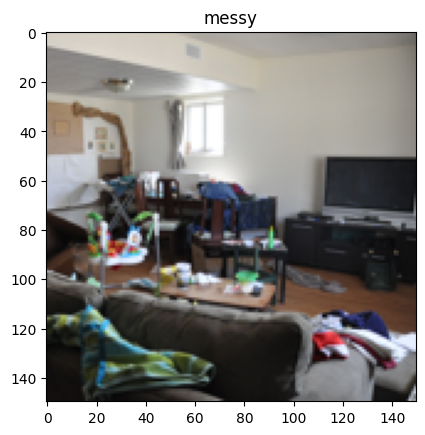

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
clean


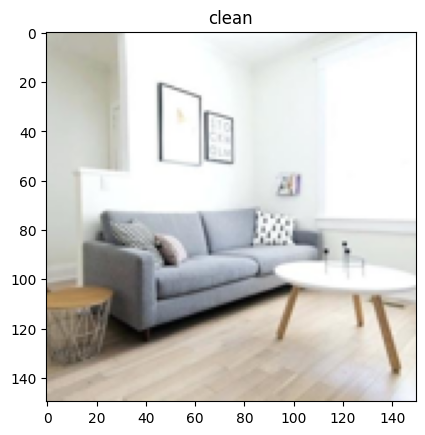

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
messy


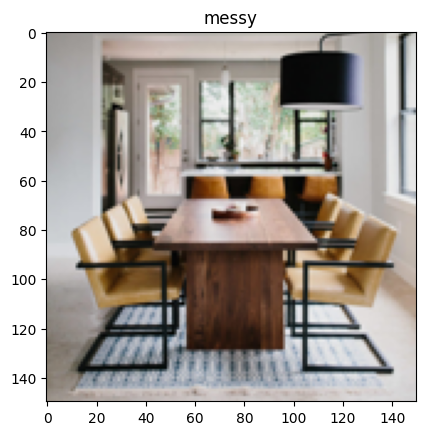

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
clean


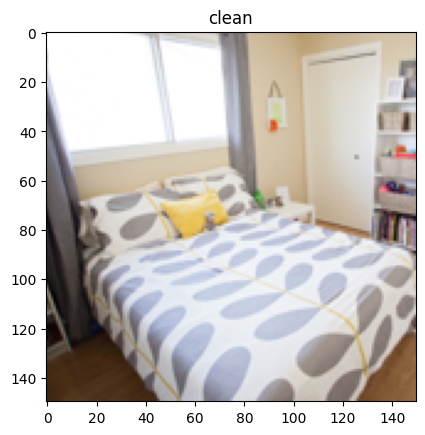

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
messy


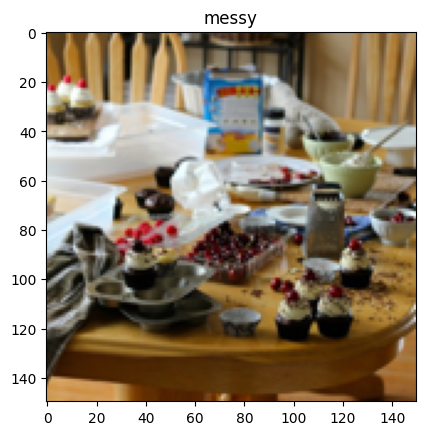

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
clean


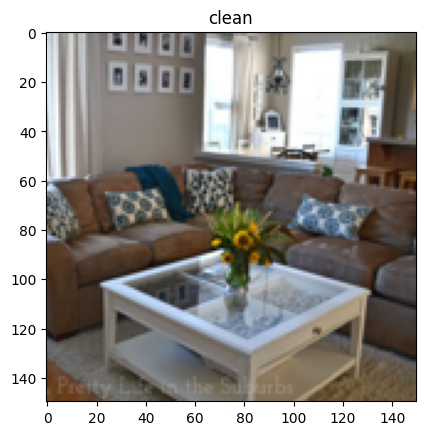

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
clean


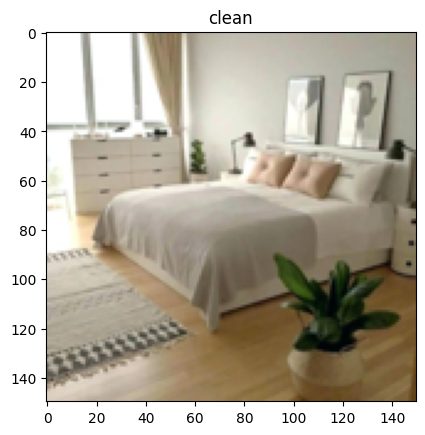

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
messy


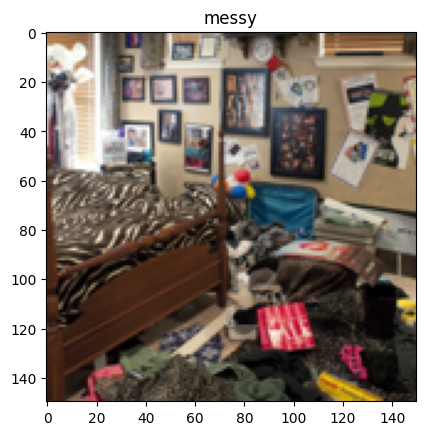

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
messy


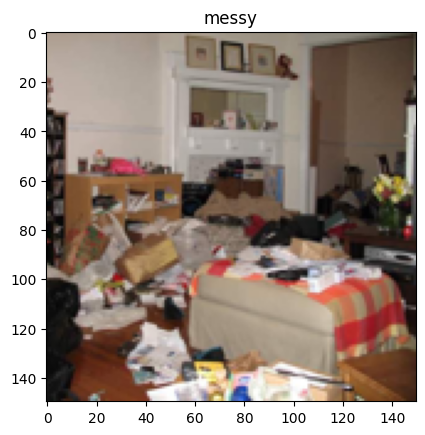

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
messy


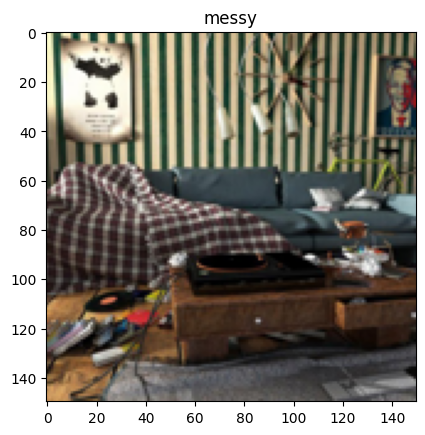

In [65]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from glob import glob
%matplotlib inline

def predict_image_class(model, image_path):
    img = Image.open(image_path).resize((150, 150))
    imgplot = plt.imshow(img)
    x = np.expand_dims(np.array(img), axis=0)
    classes = model.predict(x, batch_size=10)

    if classes[0] == 0:
        plt.title("clean")
        print('clean')
    else:
        print('messy')
        plt.title("messy")
    plt.show()

# Ambil semua file gambar dari folder
image_paths = glob("/content/dataset/test/*.png")  # bisa juga pakai *.jpg kalau kamu mau jpg juga

# Loop dan prediksi
for image_path in image_paths:
    predict_image_class(model, image_path)